In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("/hpi/fs00/home/lukas.laskowski/Masterarbeit/NumbER/NumbER/scripts/runs_test.csv")
embitto_filter= {
	'lr': 3e-5,
 	'should_finetune': True,
	'should_pretrain': False,
	'matching_solution': 'embitto',
	'finetune_batch_size': 50,
 	'num_finetune_epochs': 40,
	#'num_pretrain_epochs': ??,
	#'pretrain_batch_size': 50,
	'output_embedding_size': 256,
	#'include_numerical_features_in_textual': True,
	#'lm': 'roberta',
	#'fp16': True,
	#'max_len': 256,
	'numerical_config_model': None,
	#'numerical_config_model': "NumbER.matching_solutions.embitto.numerical_components.value_embeddings.ValueBaseEmbeddings",
	#'numerical_config_model': "NumbER.matching_solutions.embitto.numerical_components.dice.DICEEmbeddingAggregator",
 #'numerical_config_embedding_size': 128,
	# 'numerical_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.pair_based_numeric_formatter',
	# 'numerical_config_pretrain_formatter': 'NumbER.matching_solutions.embitto.formatters.dummy_formatter',
	# 'numerical_config_0': None,
	'textual_config_model': 'NumbER.matching_solutions.embitto.textual_components.base_roberta.BaseRoberta',
	'textual_config_max_length': 256,
	'textual_config_embedding_size': 256,
	'textual_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.textual_scientific',#_scientific',
	#'textual_config_pretrain_formatter': ??,
	'textual_config_0': None, 
}

ditto_filter = {
	"batch_size": 50,
	"n_epochs": 40,
	"lr": 3e-5,
	"max_len": 256,
	"lm": "roberta",
	"fp16": True,
 	"matching_solution": "ditto",
}
deep_matcher_filter = {
	"batch_size": 50,
	"epochs": 40,
 	"matching_solution": "deep_matcher",
}
# Create the 3x3 grid of boxplots
#plt.figure(figsize=(12, 24))  # Adjust the figure size if needed
y_data = []
labels=[]
means = []
ditto_mean = 0.0
ditto_y_data = []
result_df = pd.DataFrame(columns=["dataset", "f1_not_closed", "recall_not_closed", "precision_not_closed", "training_time"])
# Iterate through each unique group and create a boxplot for each one
for i, group in enumerate([
    "complete_prompt_formatter", "deep_matcher", "ditto"
]):
    filtered_df = df
    if group == "ditto":
        filter = ditto_filter
    elif group == "deep_matcher":
        filter = deep_matcher_filter
    else:
        embitto_filter["textual_config_finetune_formatter"] = f"NumbER.matching_solutions.embitto.formatters.{group}"
        filter = embitto_filter
    for key, value in filter.items():
        if value is not None:
            filtered_df = filtered_df[filtered_df[key] == value]
        else:
            filtered_df = filtered_df[filtered_df[key].isnull()]
    filtered_df = filtered_df.drop_duplicates(subset=['tags', 'dataset', 'run'])
    filtered_df = filtered_df[~filtered_df["run"].isnull()]
    #filtered_df = filtered_df[filtered_df["dataset"].isin(["baby_products_numeric","books3_all","books3_numeric","books3_numeric_no_isbn","earthquakes","vsx_small","x2_all","x2_combined","x3_all","x3_combined","x3_numeric" ])]
    filtered_df = filtered_df[filtered_df["dataset"].isin(["baby_products_numeric","books3_numeric","books3_numeric_no_isbn", "x2_numeric","x3_numeric","earthquakes","vsx_small", "baby_products_all", 'baby_products_combined', 'books3_combined', 'books3_all', 'books3_all_no_isbn', 'books3_combined_no_isbn', 'x2_all', 'x2_combined', 'x3_all', 'x3_combined', "2MASS_small_no_n", "protein_small"])]
    filtered_df['training_time'] = filtered_df['training_time'].apply(lambda x: -x/60)
    aggregate = filtered_df.groupby(["dataset", "state"]).agg({"f1_not_closed": ["mean", "std", "count"], "recall_not_closed": ["mean"], "precision_not_closed": ["mean"], "training_time": ["mean", "std"]})
    aggregate = aggregate[aggregate["f1_not_closed"]["count"] > 4]
    for idx, row in aggregate.iterrows():
        if group == "ditto":
            solution = "SOTA"
        elif group == "deep_matcher":
            solution = "SOTA"
        else:
            solution = "NumbER"
        result_df = result_df.append({"dataset": idx[0], "matching_solution": solution, "f1_not_closed": row["f1_not_closed"]["mean"], "recall_not_closed": row["recall_not_closed"]["mean"], "precision_not_closed": row["precision_not_closed"]["mean"], "training_time": row["training_time"]["mean"],"algorithm": group},  ignore_index=True)
    mean = aggregate['f1_not_closed'].mean()['mean']
    if group == "ditto":
        ditto_mean = mean
        ditto_y_data = aggregate['f1_not_closed']['mean'].values
        continue
    elif group == "deep_matcher":
        aggregate = filtered_df.groupby(["dataset", "state"]).agg({"f1_reported": ["mean", "std", "count"], "recall_not_closed": ["mean"], "training_time": ["mean", "std"]})
        deep_matcher_mean = aggregate['f1_reported'].mean()['mean']
        deep_matcher_y_data = aggregate['f1_reported']['mean'].values
        continue
    print(group)
    print(mean)
    means.append(mean)
    y_data.append(aggregate['f1_not_closed']['mean'].values)
    labels.append(f"{group}")#\nMean: {mean:.2f}")
    means_sorted = np.argsort(means)
labels = np.array(labels)
result_df.to_csv("result_df.csv")
means = np.array(means)
y_data = np.array(y_data)
labels = [*labels[means_sorted[::]], "ditto", "deep_matcher"]
means = [*means[means_sorted[::]], ditto_mean, deep_matcher_mean]
y_data = [*y_data[means_sorted[::]], ditto_y_data, deep_matcher_y_data]
print(result_df)

/tmp/ipykernel_995882/2359426303.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"dataset": idx[0], "matching_solution": solution, "f1_not_closed": row["f1_not_closed"]["mean"], "recall_not_closed": row["recall_not_closed"]["mean"], "precision_not_closed": row["precision_not_closed"]["mean"], "training_time": row["training_time"]["mean"],"algorithm": group},  ignore_index=True)
/tmp/ipykernel_995882/2359426303.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"dataset": idx[0], "matching_solution": solution, "f1_not_closed": row["f1_not_closed"]["mean"], "recall_not_closed": row["recall_not_closed"]["mean"], "precision_not_closed": row["precision_not_closed"]["mean"], "training_time": row["training_time"]["mean"],"algorithm": group},  ignore_in

complete_prompt_formatter
0.8419138455092604
                    dataset  f1_not_closed  recall_not_closed  \
0          2MASS_small_no_n       0.976676           0.996000   
1         baby_products_all       0.863831           0.914176   
2    baby_products_combined       0.924997           0.935888   
3     baby_products_numeric       0.389688           0.373180   
4                books3_all       0.998830           1.000000   
5        books3_all_no_isbn       0.983500           0.985882   
6           books3_combined       0.990532           0.985991   
7   books3_combined_no_isbn       0.980312           0.988111   
8            books3_numeric       0.994038           0.990583   
9    books3_numeric_no_isbn       0.727910           0.736508   
10              earthquakes       0.776652           0.780495   
11            protein_small       0.317413           0.733477   
12                vsx_small       0.958926           0.979505   
13                   x2_all       0.909354   

/tmp/ipykernel_995882/2520070965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ditto['dataset'] = pd.Categorical(ditto['dataset'], categories=mapping, ordered=True)
/tmp/ipykernel_995882/2520070965.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embitto['dataset'] = pd.Categorical(embitto['dataset'], categories=mapping, ordered=True)
/tmp/ipykernel_995882/2520070965.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

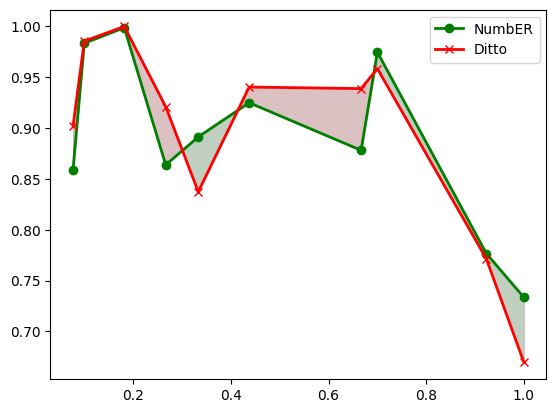

dict_keys([0.07692307692307693, 0.1, 0.18181818181818182, 0.26666666666666666, 0.3333333333333333, 0.4375, 0.6666666666666666, 0.7, 0.9230769230769231, 1.0])
[-0.04306901 -0.00206865 -0.00116959 -0.05725223  0.05400436 -0.01543262
 -0.0607132   0.01621362  0.00520841  0.0639595 ]


In [5]:
mapping_dict = {
'x3_all': 1/13,
'x2_all': 1/13,
'books3_all_no_isbn': 1/10,
'books3_all': 2/11,
'baby_products_all': 4/15,
'x2_combined': 5/15,
'baby_products_combined': 7/16,
'books3_combined_no_isbn': 6/9,
'books3_combined': 7/10,
'vsx_small': 7/10,
'earthquakes': 12/13,
'baby_products_numeric': 7/7,
'books3_numeric_no_isbn': 6/6,
'books3_numeric': 7/7,
'x3_combined': 10/15,
'x2_numeric': 10/10,
'x3_numeric': 10/10,
'2MASS_small_no_n': 10/10,
'protein_small': 10/10,
}
mapping = sorted(mapping_dict, key=lambda k: mapping_dict[k])
mapping_values = [mapping_dict[key] for key in mapping]
#print(result_df)
#create line chart using mapping as x-values and f1_not_closed as y-values
# import matplotlib.pyplot as plt
ditto = result_df[result_df['algorithm'] == "ditto"]  
ditto['dataset'] = pd.Categorical(ditto['dataset'], categories=mapping, ordered=True)
ditto = ditto.sort_values('dataset')['f1_not_closed'].reset_index()
embitto = result_df[result_df['algorithm'] == "complete_prompt_formatter"]  
embitto['dataset'] = pd.Categorical(embitto['dataset'], categories=mapping, ordered=True)
embitto = embitto.sort_values('dataset')['f1_not_closed'].reset_index()
dm = result_df[result_df['algorithm'] == "deep_matcher"]  
dm['dataset'] = pd.Categorical(dm['dataset'], categories=mapping, ordered=True)
dm = dm.sort_values('dataset')['f1_not_closed'].reset_index()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df = pd.DataFrame({'label': mapping, 'x': mapping_values, 'ditto': ditto['f1_not_closed'], 'embitto': embitto['f1_not_closed'], 'dm': dm['f1_not_closed'], 'dif': embitto['f1_not_closed'] - ditto['f1_not_closed'] })
ditto = df.groupby('x')['ditto'].mean().values
dm = df.groupby('x')['dm'].mean().values
embitto = df.groupby('x')['embitto'].mean().values
dif = df.groupby('x')['dif'].mean().values
x = df.groupby('x').groups.keys()
fig, ax = plt.subplots()
plt.plot( x,embitto, linewidth=2, color="green", marker = "o", label="NumbER")
plt.plot( x,ditto, linewidth=2, color="red", marker = "x", label="Ditto")
plt.fill_between(x, embitto, ditto, color='grey', alpha=0.3)
plt.fill_between(x, embitto, ditto, where=ditto>embitto, facecolor='red', interpolate=True, alpha=0.1)
plt.fill_between(x, embitto, ditto, where=ditto<=embitto, facecolor='green', interpolate=True, alpha=0.1)
#plt.ylim(-0.2, 0.2)
#plt.plot( mapping_values,ditto, marker='', linewidth=2)
#plt.plot( mapping, dm, marker='', linewidth=2, linestyle='dashed', label="toto")
plt.legend()
plt.show()

#barchart which plots the difference between embitto and ditto
print(x)
print(dif)
#ax.plot(x, dif, color='green')
#ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
fig.show()

In [4]:
# algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,execute_main_time,execute_postprocess_time,status,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category,algo_family,algo_area,algo_display_name
# ARIMA,GutenTAG,cbf-combined-diff-1,GHA,UNIVARIATE,NumbER,UNIVARIATE,,,,71.41411137580872,,Status.OK,,1,"{""differencing_degree"": 1, ""distance_metric"": ""twed"", ""max_lag"": 1000, ""max_p"": 5, ""max_q"": 5, ""p_start"": 1, ""q_start"": 1, ""random_state"": 42, ""window_size"": 100}",c65230762e5361a11b4faac7164f95bf,0.8153191489361702,0.4652479398325147,0.4532154876827748,0.4547417361111111,71.41411137580872,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA
result_df["algo_display_name"] = result_df["algorithm"]
result_df["algo_training_type"] = result_df["matching_solution"]
result_df["precision"] = result_df["precision_not_closed"]
result_df["f1"] = result_df["f1_not_closed"]
result_df["recall"] = result_df["recall_not_closed"]
result_df["algo_input_dimensionality"] = "TEST"
result_df["dataset_training_type"] = "TEST"
result_df["dataset_input_dimensionality"] = "TEST"
result_df["train_preprocess_time"] = 0
result_df["error_category"] = "- OK -"
result_df["algo_family"] = "forecasting"
result_df["algo_area"] = "Statistics (Regression & Forecasting)"
result_df["collection"] ="TEST"
result_df.to_csv("result_df.csv", index=False)

In [34]:
result_df["algo_display_name"].unique()

array(['complete_prompt_formatter',
       'complete_prompt_formatter_scientific',
       'complete_prompt_formatter_min_max_scaled',
       'textual_prompt_formatter', 'textual_scientific',
       'textual_min_max_scaled', 'pair_based_ditto_formatter',
       'pair_based_ditto_formatter_scientific', 'text_sim_formatter',
       'deep_matcher', 'ditto'], dtype=object)

In [35]:
rename = {
     'pair_based_ditto_formatter': 'Naive',
     'pair_based_ditto_formatter_scientific': 'NaiveScientific',
     'complete_prompt_formatter': 'Distance',
     'complete_prompt_formatter_scientific': 'DistanceScientific',
     'complete_prompt_formatter_min_max_scaled': 'MinMaxDistance',
     'text_sim_formatter': 'TextualDistance',
     'textual_prompt_formatter': 'AttributePair',
     'textual_scientific': 'AttributePairScientific',
     'textual_min_max_scaled': 'AttributePairMinMax',
     'deep_matcher': 'DeepMatcher',
     'ditto': 'Ditto',
}
#rename all values of result_df in column algorithm according to rename
result_df['algorithm'] = result_df['algorithm'].apply(lambda x: rename[x])
result_df.to_csv("result_df.csv", index=False)

In [ ]:
relation_of_numerical_columns = {
	
}